In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

# CIFAR-10 데이터 로드
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# 데이터 정규화
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# 레이블 원-핫 인코딩
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [2]:
class PatchExtract(layers.Layer):
    def __init__(self, patch_size):
        super(PatchExtract, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [3]:
class PatchEmbedding(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEmbedding, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [4]:
class MultiHeadAttention(layers.Layer):
    def __init__(self, projection_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.projection_dim = projection_dim
        self.num_heads = num_heads
        self.head_dim = projection_dim // num_heads
        self.query_dense = layers.Dense(projection_dim)
        self.key_dense = layers.Dense(projection_dim)
        self.value_dense = layers.Dense(projection_dim)
        self.combine_heads = layers.Dense(projection_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.head_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)

        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.projection_dim))
        output = self.combine_heads(concat_attention)
        return output

In [5]:
class TransformerBlock(layers.Layer):
    def __init__(self, projection_dim, num_heads, mlp_dim, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.mha = MultiHeadAttention(projection_dim, num_heads)
        self.mlp = keras.Sequential(
            [
                layers.Dense(mlp_dim, activation=tf.nn.gelu),
                layers.Dropout(dropout),
                layers.Dense(projection_dim),
                layers.Dropout(dropout),
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout)
        self.dropout2 = layers.Dropout(dropout)

    def call(self, inputs, training):
        attn_output = self.mha(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        mlp_output = self.mlp(out1)
        mlp_output = self.dropout2(mlp_output, training=training)
        return self.layernorm2(out1 + mlp_output)

In [6]:
class VisionTransformer(keras.Model):
    def __init__(self, image_size, patch_size, num_classes, d_model, num_heads, mlp_dim, num_layers, dropout=0.1):
        super(VisionTransformer, self).__init__()
        num_patches = (image_size // patch_size) ** 2
        self.patch_dim = 3 * patch_size ** 2

        self.patch_extract = PatchExtract(patch_size)
        self.patch_embedding = PatchEmbedding(num_patches, d_model)
        self.dropout = layers.Dropout(dropout)

        self.transformer_blocks = [
            TransformerBlock(d_model, num_heads, mlp_dim, dropout)
            for _ in range(num_layers)
        ]

        self.mlp_head = keras.Sequential(
            [
                layers.LayerNormalization(epsilon=1e-6),
                layers.Dense(mlp_dim, activation=tf.nn.gelu),
                layers.Dropout(dropout),
                layers.Dense(num_classes),
            ]
        )

    def call(self, x, training):
        patches = self.patch_extract(x)
        embedding = self.patch_embedding(patches)
        embedding = self.dropout(embedding, training=training)

        for block in self.transformer_blocks:
            embedding = block(embedding, training=training)

        representation = tf.reduce_mean(embedding, axis=1)
        return self.mlp_head(representation)

In [37]:
image_size = 32  # CIFAR-10 이미지 크기
patch_size = 4
num_classes = 10
d_model = 64
num_heads = 8
mlp_dim = 128
num_layers = 6
dropout = 0.2

model = VisionTransformer(
    image_size=image_size,
    patch_size=patch_size,
    num_classes=num_classes,
    d_model=d_model,
    num_heads=num_heads,
    mlp_dim=mlp_dim,
    num_layers=num_layers,
    dropout=dropout,
)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.CategoricalAccuracy(name="accuracy")],
)

In [42]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=125,
    epochs=100,
    validation_split=0.1,
    callbacks=[keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True)],
)

test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

Epoch 1/100
450/450 [==============================] - 17s 38ms/step - loss: 0.7967 - accuracy: 0.7136 - val_loss: 0.9237 - val_accuracy: 0.6894
Epoch 2/100
450/450 [==============================] - 16s 35ms/step - loss: 0.7857 - accuracy: 0.7185 - val_loss: 0.9172 - val_accuracy: 0.6876
Epoch 3/100
450/450 [==============================] - 16s 34ms/step - loss: 0.7790 - accuracy: 0.7198 - val_loss: 0.9416 - val_accuracy: 0.6882
Epoch 4/100
450/450 [==============================] - 15s 34ms/step - loss: 0.7714 - accuracy: 0.7232 - val_loss: 0.9603 - val_accuracy: 0.6842
Epoch 5/100
450/450 [==============================] - 15s 34ms/step - loss: 0.7663 - accuracy: 0.7258 - val_loss: 0.9220 - val_accuracy: 0.6916
Epoch 6/100
450/450 [==============================] - 16s 35ms/step - loss: 0.7622 - accuracy: 0.7282 - val_loss: 0.9241 - val_accuracy: 0.6958
Epoch 7/100
450/450 [==============================] - 15s 34ms/step - loss: 0.7568 - accuracy: 0.7279 - val_loss: 0.9066 - val_ac

Epoch 1/100 - Loss: 0.7192 - Accuracy: 0.7427 - Val Loss: 0.9243 - Val Accuracy: 0.6973 - Time: 23.22s
Epoch 2/100 - Loss: 0.7074 - Accuracy: 0.7479 - Val Loss: 0.9555 - Val Accuracy: 0.6880 - Time: 23.01s
Epoch 3/100 - Loss: 0.7041 - Accuracy: 0.7474 - Val Loss: 0.9756 - Val Accuracy: 0.6866 - Time: 22.64s
Epoch 4/100 - Loss: 0.6935 - Accuracy: 0.7503 - Val Loss: 0.9611 - Val Accuracy: 0.6960 - Time: 22.87s
Epoch 5/100 - Loss: 0.6868 - Accuracy: 0.7520 - Val Loss: 0.9981 - Val Accuracy: 0.6876 - Time: 22.79s
Epoch 6/100 - Loss: 0.6849 - Accuracy: 0.7540 - Val Loss: 0.9610 - Val Accuracy: 0.6908 - Time: 22.88s
Epoch 7/100 - Loss: 0.6775 - Accuracy: 0.7584 - Val Loss: 0.9504 - Val Accuracy: 0.6951 - Time: 23.18s
Epoch 8/100 - Loss: 0.6737 - Accuracy: 0.7576 - Val Loss: 0.9377 - Val Accuracy: 0.7004 - Time: 23.36s
Epoch 9/100 - Loss: 0.6689 - Accuracy: 0.7582 - Val Loss: 1.0136 - Val Accuracy: 0.6855 - Time: 22.77s
Epoch 10/100 - Loss: 0.6662 - Accuracy: 0.7612 - Val Loss: 0.9388 - Val A

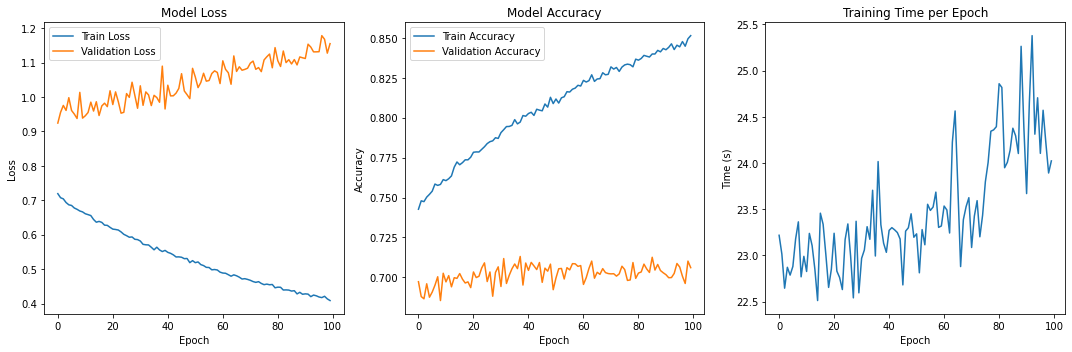

In [43]:
import matplotlib.pyplot as plt
import time

def train_and_visualize(model, x_train, y_train, x_test, y_test, epochs=100, batch_size=64):
    # 훈련 히스토리를 저장할 리스트
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    time_history = []

    for epoch in range(epochs):
        start_time = time.time()

        # 훈련
        history = model.fit(
            x_train, y_train,
            batch_size=batch_size,
            epochs=1,
            validation_data=(x_test, y_test),
            verbose=0
        )

        # 히스토리 저장
        train_loss_history.append(history.history['loss'][0])
        train_acc_history.append(history.history['accuracy'][0])
        val_loss_history.append(history.history['val_loss'][0])
        val_acc_history.append(history.history['val_accuracy'][0])

        end_time = time.time()
        time_history.append(end_time - start_time)

        # 진행 상황 출력
        print(f"Epoch {epoch+1}/{epochs} - "
              f"Loss: {train_loss_history[-1]:.4f} - "
              f"Accuracy: {train_acc_history[-1]:.4f} - "
              f"Val Loss: {val_loss_history[-1]:.4f} - "
              f"Val Accuracy: {val_acc_history[-1]:.4f} - "
              f"Time: {time_history[-1]:.2f}s")

    # 결과 시각화
    plt.figure(figsize=(15, 5))

    # 손실 그래프
    plt.subplot(1, 3, 1)
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # 정확도 그래프
    plt.subplot(1, 3, 2)
    plt.plot(train_acc_history, label='Train Accuracy')
    plt.plot(val_acc_history, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # 훈련 시간 그래프
    plt.subplot(1, 3, 3)
    plt.plot(time_history)
    plt.title('Training Time per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Time (s)')

    plt.tight_layout()
    plt.show()

# 사용 예시
# train_and_visualize(model, x_train, y_train, x_test, y_test, epochs=100, batch_size=64)

train_and_visualize(model, x_train, y_train, x_test, y_test, epochs=100, batch_size=64)